<a href="https://colab.research.google.com/github/AryaveerGupta/Transfer_learning_and_visualisation_of_CNN/blob/main/transfer_learning_and_visualization_of_cnn_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
# from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.utils import load_img
import numpy as np
import pandas as pd
from keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Display
# from IPython.display import Image, display
import matplotlib.cm as cm
from PIL import Image as PILImage

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# curr_path = os.getcwd()
random_seed =42

#Adam Optimiser params
lr=1e-3
epsilon_val=1e-8
beta1=0.9
beta2=0.999

In [ ]:
path_in = '/content/drive/MyDrive/Group_20'
path_model = '/content/drive/MyDrive/archive'
print(os.listdir(path_model))

['output_layer_epoch_2_weights.csv', 'output_layer_epoch_2_bias.csv']


In [ ]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


## Read Datasets

In [ ]:
class_names = ['brain', 'butterfly', 'ewer', 'helicopter', 'ketch']
normalization_layer = tf.keras.layers.Rescaling(1./255)

## read training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    path_in + '/train/',
    batch_size=32,
    seed = random_seed,
    image_size=(224, 224)
).map(lambda x, y: (normalization_layer(x), y))

Found 250 files belonging to 5 classes.


In [ ]:
# load validation dataset
valid_ds = tf.keras.utils.image_dataset_from_directory(
    path_in + '/val/',
    batch_size=32,
    seed = random_seed,
    image_size=(224, 224),
    shuffle=False
).map(lambda x, y: (normalization_layer(x), y))

Found 50 files belonging to 5 classes.


In [ ]:
# load test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    path_in + '/test/',
    batch_size=32,
    seed = random_seed,
    image_size=(224, 224)
).map(lambda x, y: (normalization_layer(x), y))

Found 100 files belonging to 5 classes.


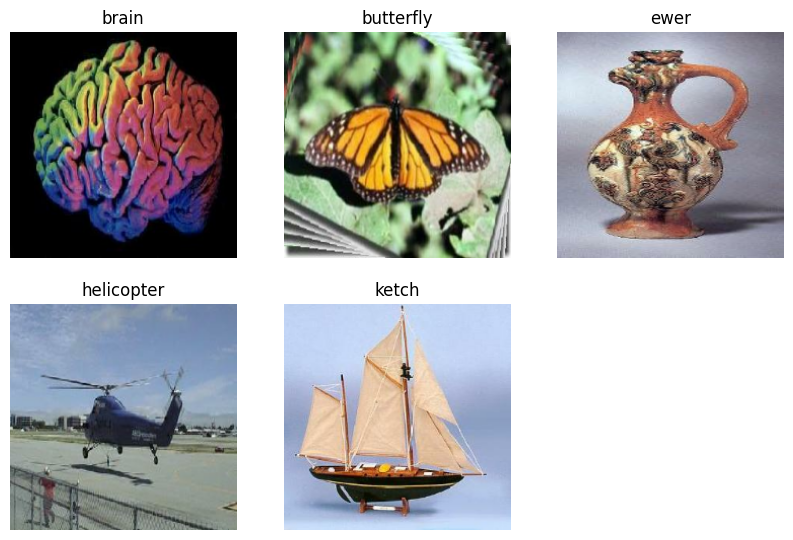

In [ ]:
image_super = [] # pairs of images and corresponding labels (will be used for plotting and other experiments)
plt.figure(figsize=(10, 10))
for i in range(5):
    label_idx = i%5
    for batch_images, batch_labels in valid_ds:
        mask = (batch_labels == label_idx)
        if tf.reduce_any(mask): #checks if any value in mask tensor is true
            indices = tf.argmax(mask)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow((batch_images[indices].numpy()*255).astype("uint8"))
            plt.title(class_names[batch_labels[indices]])
            plt.axis("off")
            image_super.append([batch_images[indices], batch_labels[indices]])
            break


## Callbacks

In [ ]:
# Define the layers whose weights you want to save
layer_names = ['output_layer']

# Define the custom callback function to save the weights of specific layers
class SaveLayerWeightsCallback(ModelCheckpoint):
    def __init__(self, filepath, layers, **kwargs):
        self.layers = layers
        self.filepath = filepath
        super().__init__(filepath, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        for layer_name in self.layers:
            layer = self.model.get_layer(layer_name)
            weights = layer.get_weights()
            if not os.path.exists(self.filepath):
              os.mkdir(self.filepath)
            filename1 = f"{layer_name}_epoch_{epoch}_weights.csv"
            filename2 = f"{layer_name}_epoch_{epoch}_bias.csv"
            filepath1 = os.path.join(self.filepath, filename1)
            filepath2 = os.path.join(self.filepath, filename2)
            # layer.save_weights(filepath)
            pd.DataFrame(weights[0]).to_csv(filepath1, index=False)
            pd.DataFrame(np.array([weights[1]])).to_csv(filepath2, index=False)
            # pd.DataFrame(weights).to_csv(filepath) # this saves array as a string and which is problamatic



In [ ]:
threshold_val = 0.0001
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3,
                                                  min_delta=threshold_val,
                                                  mode='min',
                                                  restore_best_weights=True,
                                                  verbose=1)

In [ ]:
# Create an instance of the custom callback
save_layer_weights = SaveLayerWeightsCallback(filepath='sequential-model-weights/', layers=layer_names)

## Model Definition

In [ ]:
vgg19 = tf.keras.applications.VGG19(
    include_top=True,
    weights="imagenet",
    classes=1000,
    classifier_activation="softmax"
)

In [ ]:
inp = tf.keras.layers.Input(shape=(224, 224, 3))
base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_tensor=inp,
                                          input_shape=(224, 224, 3))

## Load weights and bias for best results

In [ ]:
print(path_model)
best_w = pd.read_csv(path_model + '/output_layer_epoch_2_weights.csv', dtype='float32').values
best_b = pd.read_csv(path_model + '/output_layer_epoch_2_bias.csv', dtype='float32').values[0]

/content/drive/MyDrive/archive


## Complete Transfer Learning Model Initialization

In [ ]:
Flatten = tf.keras.layers.Flatten(name="flatten") # flatten output of last convolution layer
fc1 = tf.keras.layers.Dense(4096, activation='relu', name='fc1')
fc2 = tf.keras.layers.Dense(4096, activation='relu', name = 'fc2')
prediction = tf.keras.layers.Dense(5, activation='softmax', name='output')

imsize = [224, 224, 3]
inp = layers.Input(shape=(imsize[0], imsize[1], imsize[2]))
base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_tensor=inp,
                                          input_shape=(imsize[0], imsize[1], imsize[2]))

In [ ]:
## Creating transfer learning model using functional API
block5_pool = base_model.get_layer('block5_pool')
x = Flatten(block5_pool.output)
x = fc1(x)
x = fc2(x)
x = prediction(x)
model = tf.keras.models.Model(inputs = inp, outputs = x)

In [ ]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                       optimizer=keras.optimizers.Adam(learning_rate=lr,
                                                       epsilon=epsilon_val,
                                                       beta_1=beta1,
                                                       beta_2=beta2),
                        metrics=['accuracy'])

In [ ]:
# freeze all the convolution layers in training
for hl in model.layers:
    hl.trainable = False
model.get_layer('output').trainable = True

In [ ]:
## Change weights of last fully connected layer to have
## weights from best model weights from earlier training
model.get_layer('fc1').set_weights(vgg19.get_layer('fc1').get_weights())
model.get_layer('fc2').set_weights(vgg19.get_layer('fc2').get_weights())
model.get_layer('output').set_weights([best_w, best_b])

In [ ]:
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

## Prediction using Model and Confusion Matrix
-  best model weights is achieved in epoch 3

In [ ]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print("test accuracy = ", test_acc)
print("test loss ", test_loss)

test accuracy =  0.9599999785423279
test loss  0.1118839755654335


In [ ]:
_, train_acc = model.evaluate(train_ds, verbose=0)
_, val_acc = model.evaluate(valid_ds, verbose=0)
print(f"training accuracy = {train_acc :.3f}")
print(f"validation accuracy = {val_acc :.3f}" )

training accuracy = 1.000
validation accuracy = 0.980


In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=10):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # overall accuracy
  true_cls = 0
  for i in range(cm.shape[0]):
    true_cls += cm[i][i]
  acc_all = (true_cls/len(y_true))*100

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  # fig.colorbar(cax) # for now skip plotting heat index

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title=f"Confusion Matrix\naccuracy: {acc_all}",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

In [ ]:
def plot_confusion_matrix(data_set, label_names):
  # Get true labels
  true_labels = []
  predicted_ =[]
  for images, labels in data_set:
    true_labels += labels.numpy().tolist()
    predicted_ += model.predict(images, verbose=0).argmax(axis=1).tolist()
  make_confusion_matrix(true_labels, predicted_, label_names)


                    |------------------- confusion matrix for training datasets --------------|



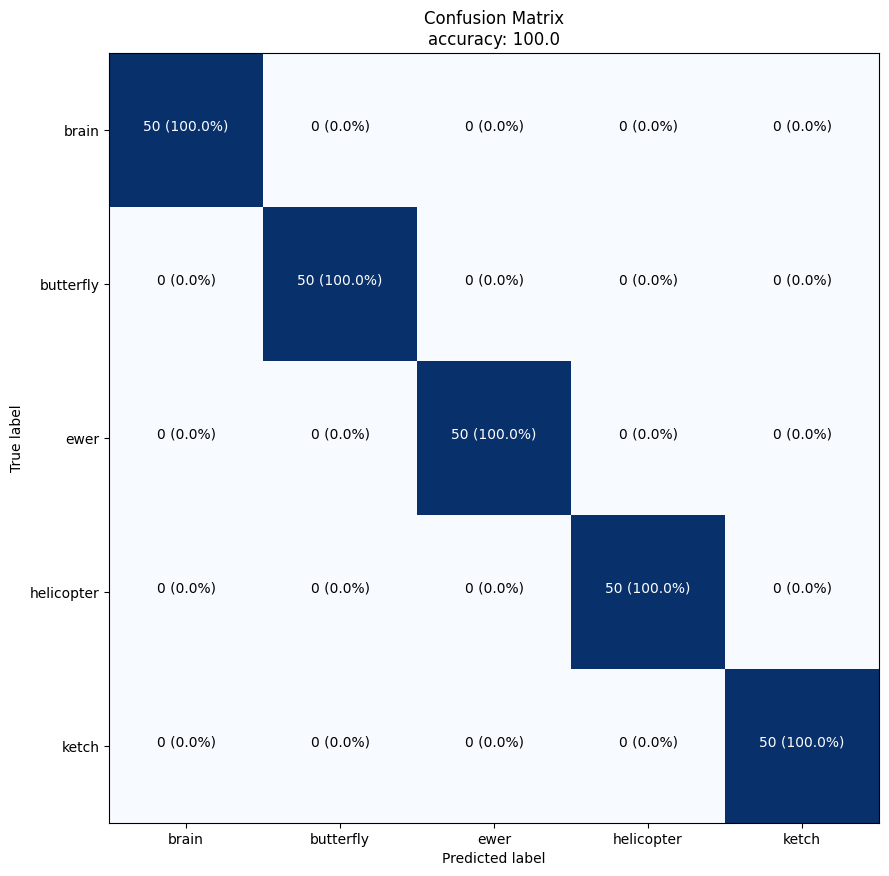

In [ ]:
print('                    |------------------- confusion matrix for training datasets --------------|')
print()
plot_confusion_matrix(train_ds, class_names)

                    |------------------- confusion matrix for validation datasets --------------|



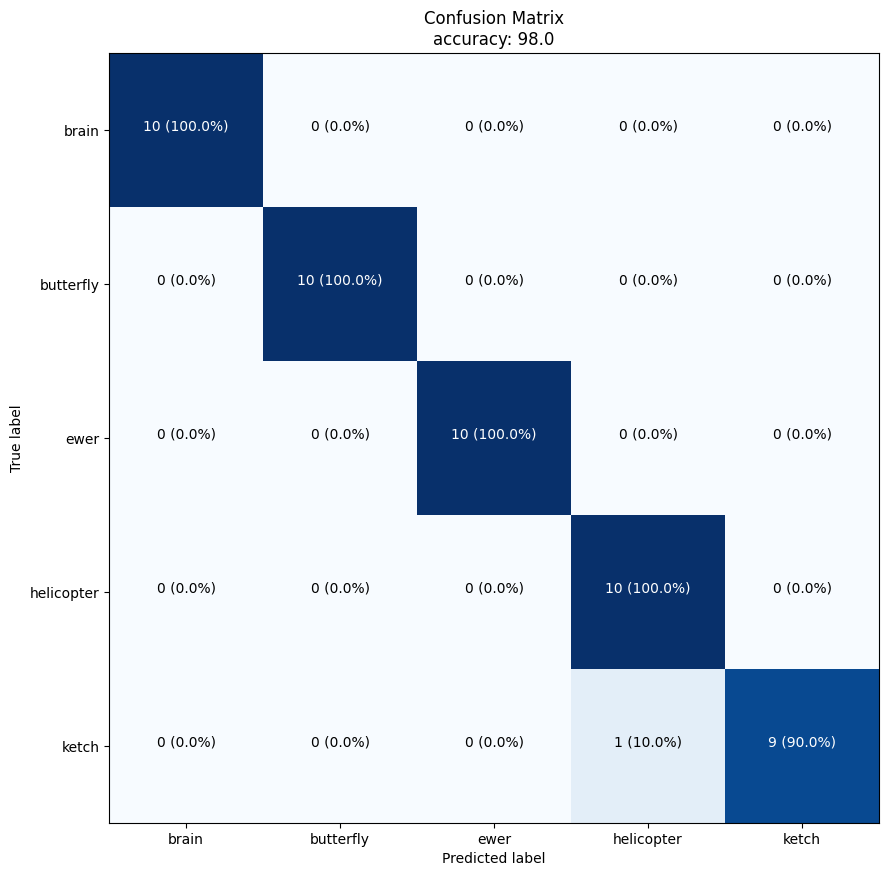

In [ ]:
print('                    |------------------- confusion matrix for validation datasets --------------|')
print()
plot_confusion_matrix(valid_ds, class_names)

                    |------------------- confusion matrix for test datasets --------------|



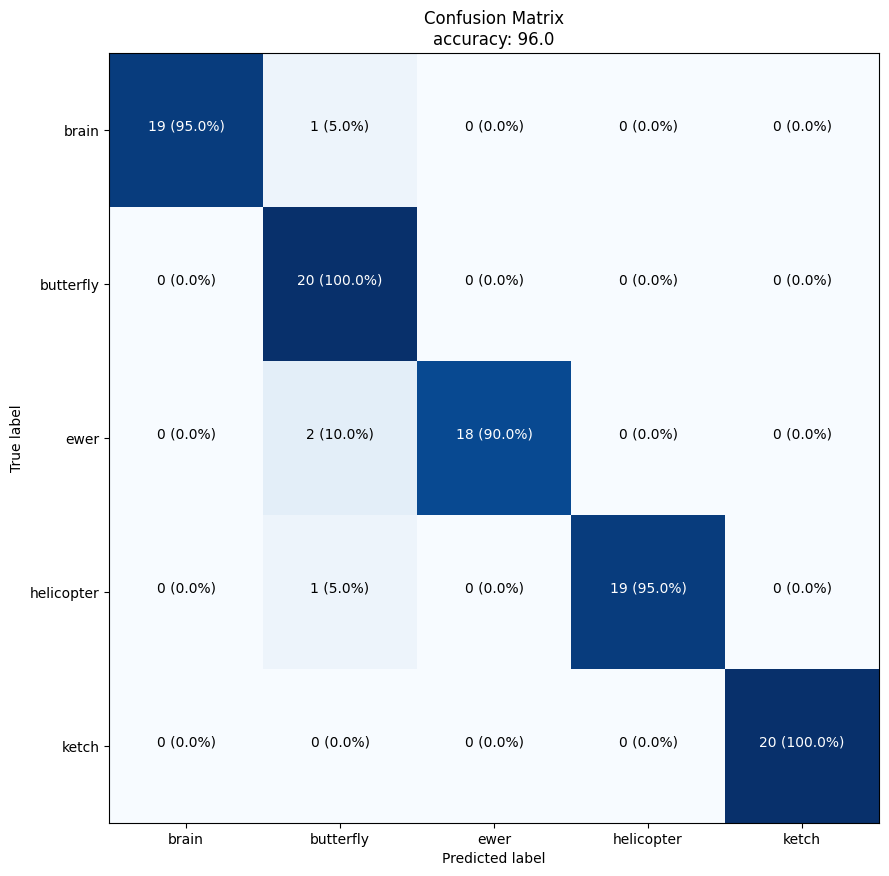

In [ ]:
print('                    |------------------- confusion matrix for test datasets --------------|')
print()
plot_confusion_matrix(test_ds, class_names)

## Receptive Field Calculation
- Tracing back to the patch in the image which causes convolution neurons to fire

In [ ]:
last_conv_layer_name, last_conv_layer_idx = "block5_conv4", 20

## create a submodel to calculate output of last convolution layer
receptive_model_calc = tf.keras.Model(
    inputs = model.input,
    outputs = model.get_layer(last_conv_layer_name).output)


In [ ]:
# function to calculate argmax of a tensor or 3D matrix
def findArgmax(arr):
    flattend_argmax = np.argmax(arr)
    req_argmax = np.unravel_index(flattend_argmax, arr.shape)
    return req_argmax[1:-1]

In [ ]:
def trace_ipnput_patch(left, right, hidd_layer, model):
    top_left = left
    bottom_right = right

    # trace From last layer to input layer
    for i in range(hidd_layer, 0, -1):
        curr_layer = model.layers[i]
        if isinstance(model.layers[i], tf.keras.layers.Conv2D):
            kernel_sz = curr_layer.kernel_size[0]
        else:
            kernel_sz = curr_layer.pool_size[0]

        s = curr_layer.strides[0]
        l_i, l_j = top_left
        r_i, r_j = bottom_right

        ## difficult case need to take care of padding (think backward)
        if curr_layer.padding == 'same':
            p = int(kernel_sz/2)
            l_ix = max(0, s * l_i - p)
            l_iy = max(0, s * l_j - p)
            r_ix = min(s * r_i + (kernel_sz-1) - p, curr_layer.output.shape[1])
            r_iy = min(s * r_j + (kernel_sz-1) - p, curr_layer.output.shape[2])
            top_left = l_ix, l_iy
            bottom_right = r_ix, r_iy

        else:
            top_left = s * l_i, s * l_j
            bottom_right = s * r_i + (kernel_sz-1), s * r_j + (kernel_sz-1)

    return top_left, bottom_right

In [ ]:
def norm_flat_image(img):
    grads_norm = img #[:,:,0]+ img[:,:,1]+ img[:,:,2]
    grads_norm = (grads_norm - tf.reduce_min(grads_norm))/ (tf.reduce_max(grads_norm)- tf.reduce_min(grads_norm))
    return grads_norm

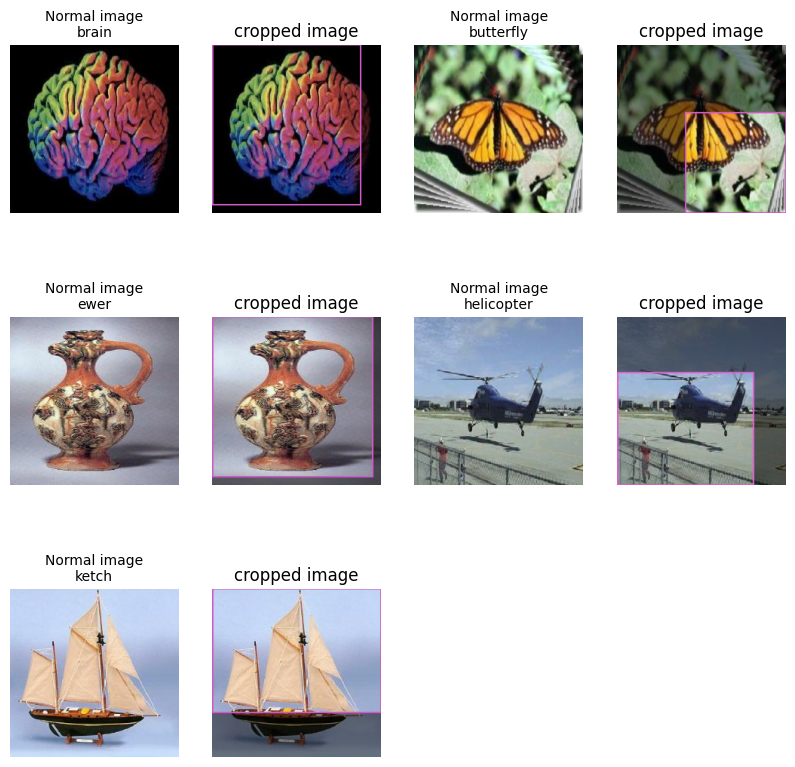

In [ ]:

plt.figure(figsize=(10, 10))
count = 0
for image_ in image_super:
    img1 = image_[0]*255
    output = receptive_model_calc.predict(np.array([img1]), verbose=0)
    maximal_neuron = findArgmax(output)
    left_idx, right_idx = trace_ipnput_patch(maximal_neuron, maximal_neuron, last_conv_layer_idx, receptive_model_calc)

    cropped_img = img1.numpy().copy()
    for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
            l_i, l_j = left_idx
            r_i, r_j = right_idx
            if(i < l_i or j < l_j or i > r_i or j > r_j):
                cropped_img[i,j,:] //=2
            elif(i in [l_i, l_i-1, l_i+1] or i in [r_i, r_i-1, r_i+1] or j in [l_j, l_j-1, l_j+1] or j in [r_j, r_j-1, r_j+1]):
                cropped_img[i,j,0] = 208
                cropped_img[i,j,1] = 89
                cropped_img[i,j,2] = 198
    ax = plt.subplot(3, 4, count + 1)
    plt.imshow(norm_flat_image(img1))
    plt.title(f'Normal image\n{class_names[image_[1]]}', fontsize=10)
    plt.axis('off')
    ax = plt.subplot(3, 4, count + 2)
    plt.imshow(norm_flat_image(cropped_img))
    plt.title('cropped image')
    plt.axis('off')
    count += 2

## Guided-backpropagation algorithm
---
#### To calculate the influence of input images on output of a neuron in convolution layer
---

In [ ]:
@tf.custom_gradient
def guidedRelu(x):
    # upstream is gradient flowing from next layer in backpropagation
    def grad(upstream):
        return tf.cast(upstream>0,tf.float32)  * tf.cast(x>0,tf.float32) * upstream
    return tf.nn.relu(x), grad

In [ ]:
## change all the relu activations to guidedRelu
## this will facilitate only positive gradients to flow during backpropagation
def changeActivation(model, isGuidedRelu=True):

    if(isGuidedRelu == True):
        for hidden_layers in model.layers:
            if hasattr(hidden_layers, 'activation'):
                if hidden_layers.activation == tf.keras.activations.relu:
                    hidden_layers.activation = guidedRelu
                    print(hidden_layers.name, " --> activation changed to guidedRelu")
    else: # change back to normal
        for hidden_layers in model.layers:
            if hasattr(hidden_layers, 'activation'):
                if hidden_layers.activation:
                    hidden_layers.activation = tf.keras.activations.relu
                    print(hidden_layers.name, " --> activation changed to relu")
    model.get_layer('output').activation = None #tf.keras.activations.softmax
    print(hidden_layers.name, " --> activation changed to softmax")
    return



In [ ]:
changeActivation(model, isGuidedRelu=True)

block1_conv1  --> activation changed to guidedRelu
block1_conv2  --> activation changed to guidedRelu
block2_conv1  --> activation changed to guidedRelu
block2_conv2  --> activation changed to guidedRelu
block3_conv1  --> activation changed to guidedRelu
block3_conv2  --> activation changed to guidedRelu
block3_conv3  --> activation changed to guidedRelu
block3_conv4  --> activation changed to guidedRelu
block4_conv1  --> activation changed to guidedRelu
block4_conv2  --> activation changed to guidedRelu
block4_conv3  --> activation changed to guidedRelu
block4_conv4  --> activation changed to guidedRelu
block5_conv1  --> activation changed to guidedRelu
block5_conv2  --> activation changed to guidedRelu
block5_conv3  --> activation changed to guidedRelu
block5_conv4  --> activation changed to guidedRelu
fc1  --> activation changed to guidedRelu
fc2  --> activation changed to guidedRelu
output  --> activation changed to softmax


In [ ]:
## we'll make use of above defined model
print("Model :summary guided backpropagation")
print(receptive_model_calc.summary())

Model :summary guided backpropagation
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPoo

In [ ]:
def maximal_activated_neuron(arr):
    flattend_argmax = np.argmax(arr)
    req_argmax = np.unravel_index(flattend_argmax, arr.shape)
    return req_argmax[1:]

In [ ]:
def guidedBP_input_influence(img, target_neuron_idx = (3,3,1)):
     # position of neuron : target_neuron_idx
    x, y, z = target_neuron_idx[0], target_neuron_idx[1], target_neuron_idx[2]
    with tf.GradientTape() as tape:
        tape.watch(img)
        all_activations = receptive_model_calc(tf.expand_dims(img, axis=0))
#         print(maximal_activated_neuron(all_activations))
        target_activations = all_activations[:, x, y, z]
    grads1 = tape.gradient(target_activations, img)

    inp_img1 = tf.expand_dims(img, axis=0)
    with tf.GradientTape() as tape:
        tape.watch(inp_img1)
        preds = model(inp_img1)
        pred_idx = tf.argmax(preds, axis=1)
        pred_val = preds[0,pred_idx[0]]
    grads2 = tape.gradient(pred_val, inp_img1)

    return {'grads_conv': grads1, 'grads_op': grads2 ,'neuron_pos': target_neuron_idx}

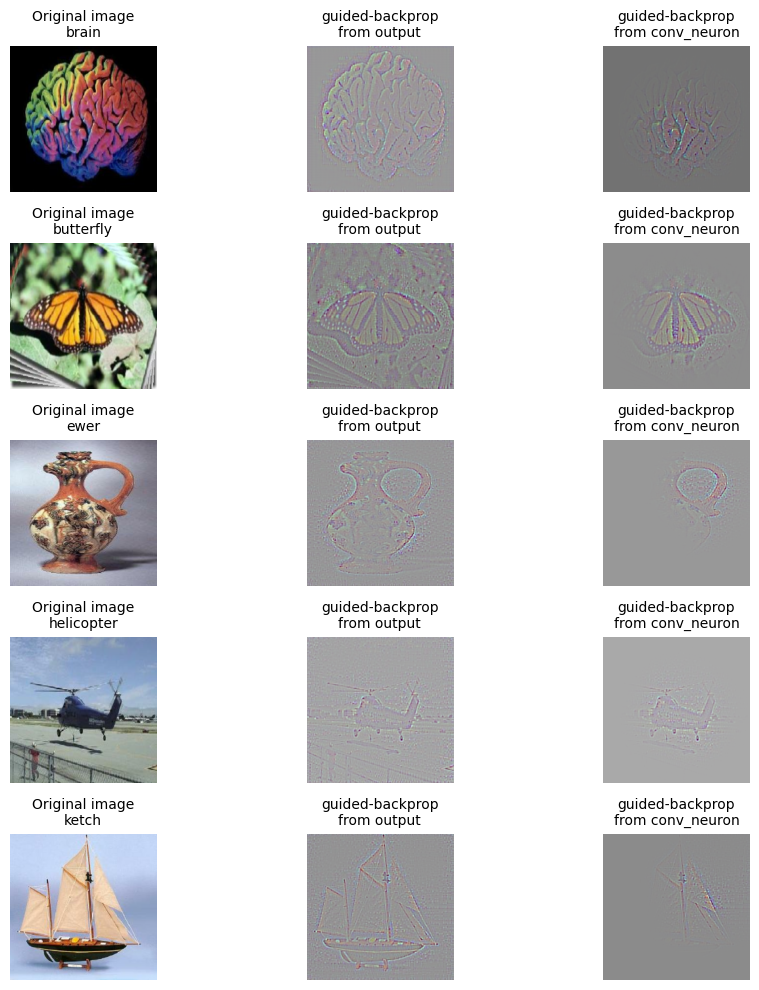

In [ ]:
# Experimentally found conv_layer neurons that are
# most influenced for these inputs
# Actually some of the neurons output do not depend on input
# 2,4--> [5,9,86] --> for even index
# 0,1,3 ---> [7,7,0] ---> for odd index

plt.figure(figsize=(10, 10))
count = 0
neuron_index_lists = [[7, 7, 0], [7, 7, 0], [5, 9, 86], [7, 7, 0], [5, 9, 86]]
for image_ in image_super:
    img1 = image_[0]
    target_neuron_idx = neuron_index_lists[image_[1]]
    grads = guidedBP_input_influence(img1, target_neuron_idx)
    ax = plt.subplot(5, 3, count + 1)
    plt.imshow(norm_flat_image(img1))
    plt.title(f'Original image\n{class_names[image_[1]]}', fontsize=10)
    plt.axis('off')
    ax = plt.subplot(5, 3, count + 2)
    plt.imshow(norm_flat_image(grads['grads_op'][0]))
    plt.title('guided-backprop\nfrom output', fontsize=10)
    plt.axis('off')
    ax = plt.subplot(5, 3, count + 3)
    plt.imshow(norm_flat_image(grads['grads_conv']))
    plt.title('guided-backprop\nfrom conv_neuron', fontsize=10)
    plt.axis('off')
    count += 3
plt.tight_layout()

## Grad-CAM class activation visualization
---
### [stackoverflow refrence link](https://stackoverflow.com/questions/60623869/gradcam-with-guided-backprop-for-transfer-learning-in-tensorflow-2-0)
---

In [ ]:
last_conv_layer_name = "block5_conv4"

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def save_and_display_gradcam(img, heatmap, cam_path = 'cam.jpg', alpha=0.4):
    # Load the original image
#     img = keras.preprocessing.image.load_img(img_path)
#     img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

#     # Save the superimposed image
#     superimposed_img.save(cam_path)

#     # Display Grad CAM
#     display(Image(cam_path))
    img = keras.preprocessing.image.img_to_array(superimposed_img)/255.0
    return img




In [ ]:
def compute_all_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    if model.layers[-1].activation != None:
        model.layers[-1].activation = None

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape(persistent=True) as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        num_class = preds.shape[1]
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channels = [preds[:, i] for i in range(num_class)]


    grads_all = [tape.gradient(class_channels[i], last_conv_layer_output) for i in range(num_class)]

    pooled_grads_all = [tf.reduce_mean(grads_all[i], axis=(0, 1, 2)) for i in range(num_class)]

    heatmap_all = []
    last_conv_layer_output = last_conv_layer_output[0]
    for i in range(num_class):
        heatmap = last_conv_layer_output @ pooled_grads_all[i][..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        heatmap_all.append(heatmap)

    # return heatmap of all classes along with class_index of predicted class as a dict
    grad_cams = {'heatmaps': heatmap_all, 'pred_idx': pred_index}
    return grad_cams

In [ ]:
changeActivation(model, isGuidedRelu=False) # undo the previous action first

block1_conv1  --> activation changed to relu
block1_conv2  --> activation changed to relu
block2_conv1  --> activation changed to relu
block2_conv2  --> activation changed to relu
block3_conv1  --> activation changed to relu
block3_conv2  --> activation changed to relu
block3_conv3  --> activation changed to relu
block3_conv4  --> activation changed to relu
block4_conv1  --> activation changed to relu
block4_conv2  --> activation changed to relu
block4_conv3  --> activation changed to relu
block4_conv4  --> activation changed to relu
block5_conv1  --> activation changed to relu
block5_conv2  --> activation changed to relu
block5_conv3  --> activation changed to relu
block5_conv4  --> activation changed to relu
fc1  --> activation changed to relu
fc2  --> activation changed to relu
output  --> activation changed to softmax


In [ ]:
array = image_super[2][0].numpy()
img_array = np.expand_dims(array, axis=0)
preds = model.predict(img_array, verbose=0 )
print("Predicted:", class_names[preds.argmax(axis=1)[0]])

Predicted: ewer


<ipython-input-144-70f5e673fdf5>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


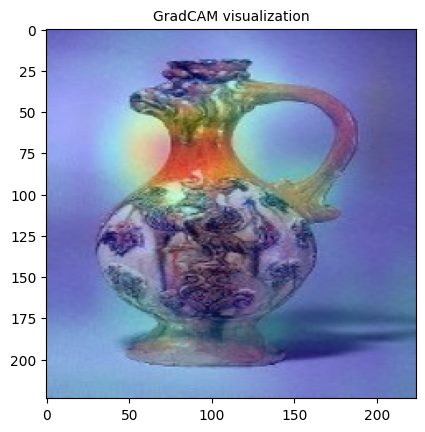

In [ ]:
array = image_super[2][0].numpy()
img_array = np.expand_dims(array, axis=0)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
img = save_and_display_gradcam(array*255, heatmap)
plt.imshow(img)
plt.title('GradCAM visualization', fontsize=10)
plt.show()

<ipython-input-144-70f5e673fdf5>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


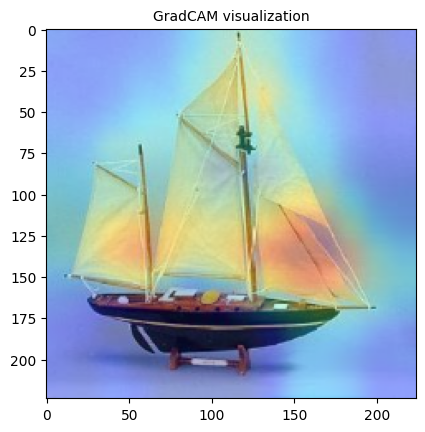

In [ ]:
array = image_super[4][0].numpy()
img_array = np.expand_dims(array, axis=0)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
img = save_and_display_gradcam(array*255, heatmap)
plt.imshow(img)
plt.title('GradCAM visualization', fontsize=10)
plt.show()

In [ ]:
def visualise_heat_map_all(img_, model=model, last_conv_layer_name = "block5_conv4"):
    array = img_.numpy()
    img_array = np.expand_dims(array, axis=0)
    cal_gradcams = compute_all_gradcam_heatmap(img_array, model, last_conv_layer_name)
    plt.figure(figsize=(10, 10))
    for i, heatmap in enumerate(cal_gradcams.get('heatmaps')):
        ax = plt.subplot(3, 3, i + 1)
        img = save_and_display_gradcam(array*255, heatmap)
        plt.imshow(img)
        title = ""
        if i == cal_gradcams.get('pred_idx'):
            title = f'with respect to actual\npredicted class: {class_names[i]}'
        else:
            title = f'with respect to\nclass: {class_names[i]}'
        plt.title(title, fontsize=10)
        plt.axis("off")


<ipython-input-144-70f5e673fdf5>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


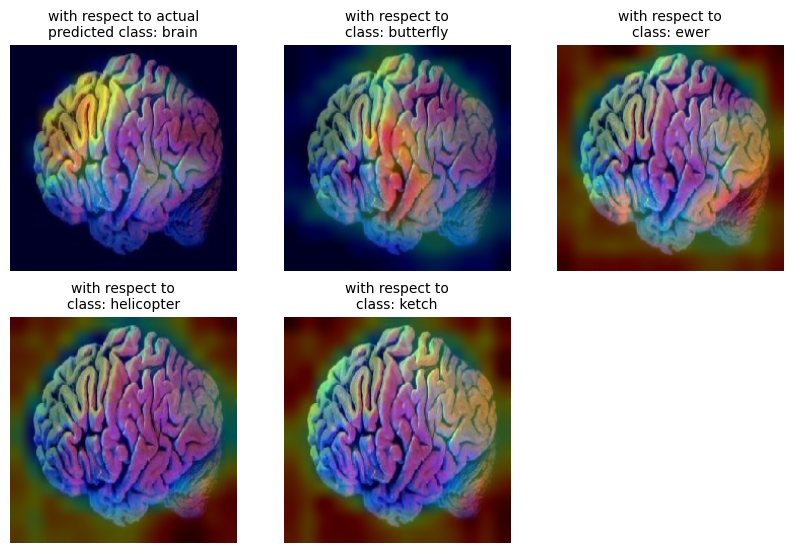

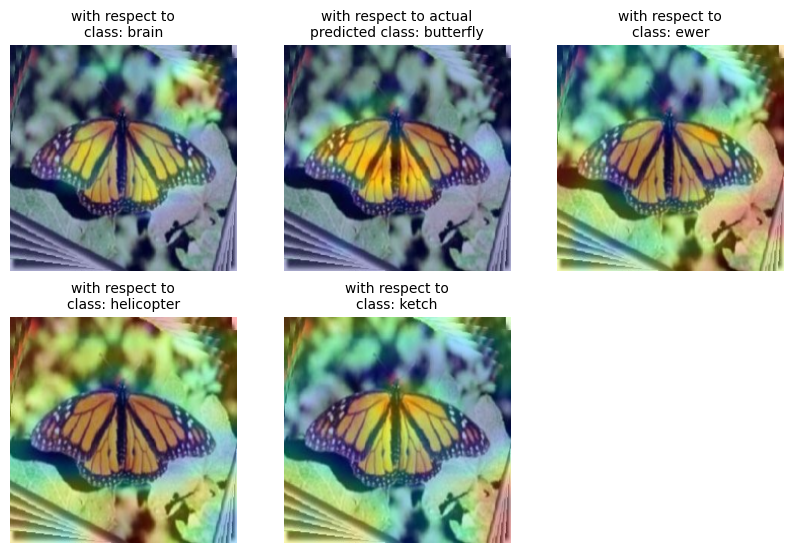

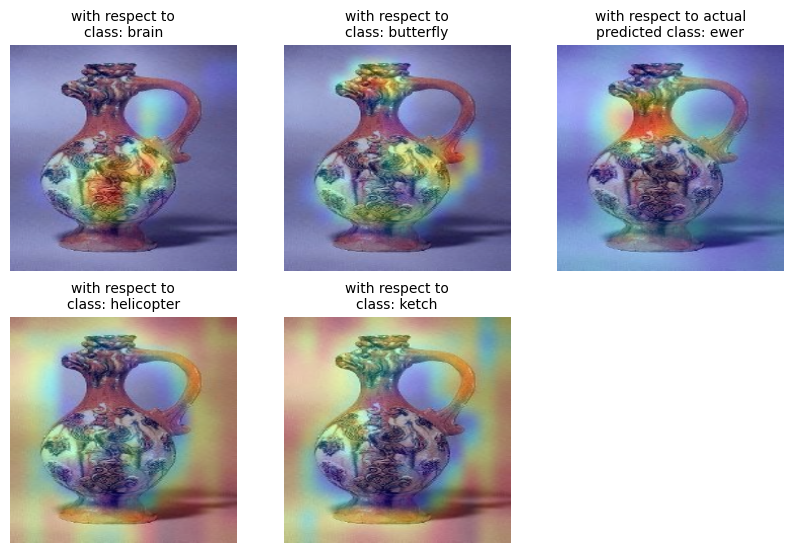

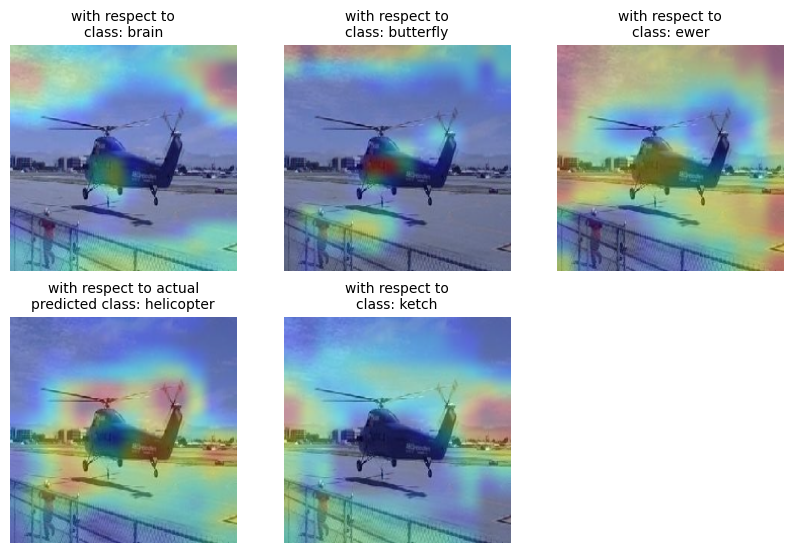

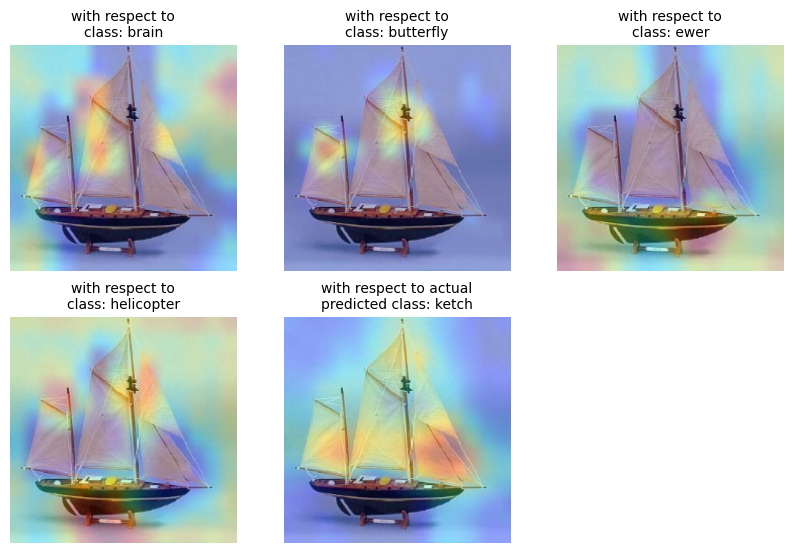

In [ ]:
for i in range(5):
    visualise_heat_map_all(image_super[i][0], model)

| |
| :-: |
| **The End** |